<a href="https://colab.research.google.com/github/Anshikkaa17/CODETECH-INTERNSHIP/blob/main/brazilian_ecommerce_analysis_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc


In [ ]:
spark = SparkSession.builder \
    .appName("Olist E-Commerce Analysis") \
    .getOrCreate()


In [ ]:
orders = spark.read.csv("/content/olist_orders_dataset.csv", header=True, inferSchema=True)
customers = spark.read.csv("/content/olist_customers_dataset.csv", header=True, inferSchema=True)
items = spark.read.csv("/content/olist_order_items_dataset.csv", header=True, inferSchema=True)
payments = spark.read.csv("/content/olist_order_payments_dataset.csv", header=True, inferSchema=True)
reviews = spark.read.csv("/content/olist_order_reviews_dataset.csv", header=True, inferSchema=True)
products = spark.read.csv("/content/olist_products_dataset.csv", header=True, inferSchema=True)
sellers = spark.read.csv("/content/olist_sellers_dataset.csv", header=True, inferSchema=True)


In [ ]:
orders.printSchema()
orders.show(5)


root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------

In [ ]:
orders.groupBy("order_status") \
      .count() \
      .orderBy("count", ascending=False) \
      .show()


+------------+-----+
|order_status|count|
+------------+-----+
|   delivered|96478|
|     shipped| 1107|
|    canceled|  625|
| unavailable|  609|
|    invoiced|  314|
|  processing|  301|
|     created|    5|
|    approved|    2|
+------------+-----+



In [ ]:
from pyspark.sql.functions import to_date

orders = orders.withColumn("order_purchase_date", to_date("order_purchase_timestamp"))

orders.groupBy("order_purchase_date") \
      .count() \
      .orderBy("order_purchase_date") \
      .show(10)



+-------------------+-----+
|order_purchase_date|count|
+-------------------+-----+
|         2016-09-04|    1|
|         2016-09-05|    1|
|         2016-09-13|    1|
|         2016-09-15|    1|
|         2016-10-02|    1|
|         2016-10-03|    8|
|         2016-10-04|   63|
|         2016-10-05|   47|
|         2016-10-06|   51|
|         2016-10-07|   46|
+-------------------+-----+
only showing top 10 rows



In [ ]:
orders_payments = orders.join(payments, on="order_id", how="inner")

orders_payments.groupBy("payment_type") \
               .agg(count("order_id").alias("order_count")) \
               .orderBy(desc("order_count")) \
               .show()


+------------+-----------+
|payment_type|order_count|
+------------+-----------+
| credit_card|      76795|
|      boleto|      19784|
|     voucher|       5775|
|  debit_card|       1529|
| not_defined|          3|
+------------+-----------+



In [ ]:
from pyspark.sql.functions import sum

orders_payments.groupBy("payment_type") \
               .agg(sum("payment_value").alias("total_sales")) \
               .orderBy(desc("total_sales")) \
               .show()


+------------+--------------------+
|payment_type|         total_sales|
+------------+--------------------+
| credit_card|1.2542084189999508E7|
|      boleto|  2869361.2699999996|
|     voucher|  379436.87000000046|
|  debit_card|  217989.79000000018|
| not_defined|                 0.0|
+------------+--------------------+



In [ ]:
from pyspark.sql.functions import datediff, to_date

items = items.withColumn("shipping_limit_date", to_date("shipping_limit_date"))
orders = orders.withColumn("delivered_date", to_date("order_delivered_customer_date"))

orders_items = orders.join(items, on="order_id", how="inner")

orders_items = orders_items.withColumn("delivery_days",
                                       datediff("delivered_date", "order_purchase_date"))

orders_items.select("order_id", "delivery_days") \
            .filter("delivery_days IS NOT NULL") \
            .show(10)


+--------------------+-------------+
|            order_id|delivery_days|
+--------------------+-------------+
|e481f51cbdc54678b...|            8|
|53cdb2fc8bc7dce0b...|           14|
|47770eb9100c2d0c4...|            9|
|949d5b44dbf5de918...|           14|
|ad21c59c0840e6cb8...|            3|
|a4591c265e18cb1dc...|           17|
|6514b8ad8028c9f2c...|           10|
|76c6e866289321a7c...|           10|
|e69bfb5eb88e0ed6a...|           18|
|e6ce16cb79ec1d90b...|           13|
+--------------------+-------------+
only showing top 10 rows



In [ ]:
orders_items_products = orders_items.join(products, on="product_id", how="inner")

orders_items_products.groupBy("product_category_name") \
                     .agg({"delivery_days": "avg"}) \
                     .orderBy("avg(delivery_days)") \
                     .show(10)


+---------------------+------------------+
|product_category_name|avg(delivery_days)|
+---------------------+------------------+
|   artes_e_artesanato| 5.666666666666667|
|           la_cuisine| 7.642857142857143|
| portateis_cozinha...| 7.928571428571429|
|    livros_importados| 7.964912280701754|
| fashion_roupa_inf...| 8.857142857142858|
|    artigos_de_festas| 9.142857142857142|
|            alimentos| 9.496993987975952|
|             pc_gamer|               9.5|
| construcao_ferram...|  9.67109634551495|
| portateis_casa_fo...| 9.794520547945206|
+---------------------+------------------+
only showing top 10 rows



In [ ]:

items_products = items.join(products, on="product_id", how="inner")


top_categories = items_products.groupBy("product_category_name") \
                               .agg(count("order_id").alias("items_sold")) \
                               .orderBy(desc("items_sold"))

top_categories.show(10)


+---------------------+----------+
|product_category_name|items_sold|
+---------------------+----------+
|      cama_mesa_banho|     11115|
|         beleza_saude|      9670|
|        esporte_lazer|      8641|
|     moveis_decoracao|      8334|
| informatica_acess...|      7827|
| utilidades_domest...|      6964|
|   relogios_presentes|      5991|
|            telefonia|      4545|
|   ferramentas_jardim|      4347|
|           automotivo|      4235|
+---------------------+----------+
only showing top 10 rows



In [ ]:

orders_customers = orders.join(customers, on="customer_id", how="inner")

most_active = orders_customers.groupBy("customer_unique_id") \
                              .agg(count("order_id").alias("orders_count")) \
                              .orderBy(desc("orders_count"))

most_active.show(10)


+--------------------+------------+
|  customer_unique_id|orders_count|
+--------------------+------------+
|8d50f5eadf50201cc...|          17|
|3e43e6105506432c9...|           9|
|6469f99c1f9dfae77...|           7|
|1b6c7548a2a1f9037...|           7|
|ca77025e7201e3b30...|           7|
|12f5d6e1cbf93dafd...|           6|
|63cfc61cee11cbe30...|           6|
|dc813062e0fc23409...|           6|
|de34b16117594161a...|           6|
|47c1a3033b8b77b3a...|           6|
+--------------------+------------+
only showing top 10 rows



In [ ]:
# Group
customers.groupBy("customer_state") \
         .agg(count("customer_id").alias("total_customers")) \
         .orderBy(desc("total_customers")) \
         .show(10)


+--------------+---------------+
|customer_state|total_customers|
+--------------+---------------+
|            SP|          41746|
|            RJ|          12852|
|            MG|          11635|
|            RS|           5466|
|            PR|           5045|
|            SC|           3637|
|            BA|           3380|
|            DF|           2140|
|            ES|           2033|
|            GO|           2020|
+--------------+---------------+
only showing top 10 rows



In [ ]:
customers.groupBy("customer_city") \
         .agg(count("customer_id").alias("total_customers")) \
         .orderBy(desc("total_customers")) \
         .show(10)


+--------------------+---------------+
|       customer_city|total_customers|
+--------------------+---------------+
|           sao paulo|          15540|
|      rio de janeiro|           6882|
|      belo horizonte|           2773|
|            brasilia|           2131|
|            curitiba|           1521|
|            campinas|           1444|
|        porto alegre|           1379|
|            salvador|           1245|
|           guarulhos|           1189|
|sao bernardo do c...|            938|
+--------------------+---------------+
only showing top 10 rows



/tmp/ipython-input-2962213591.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat_pd, x="items_sold", y="product_category_name", palette="viridis")


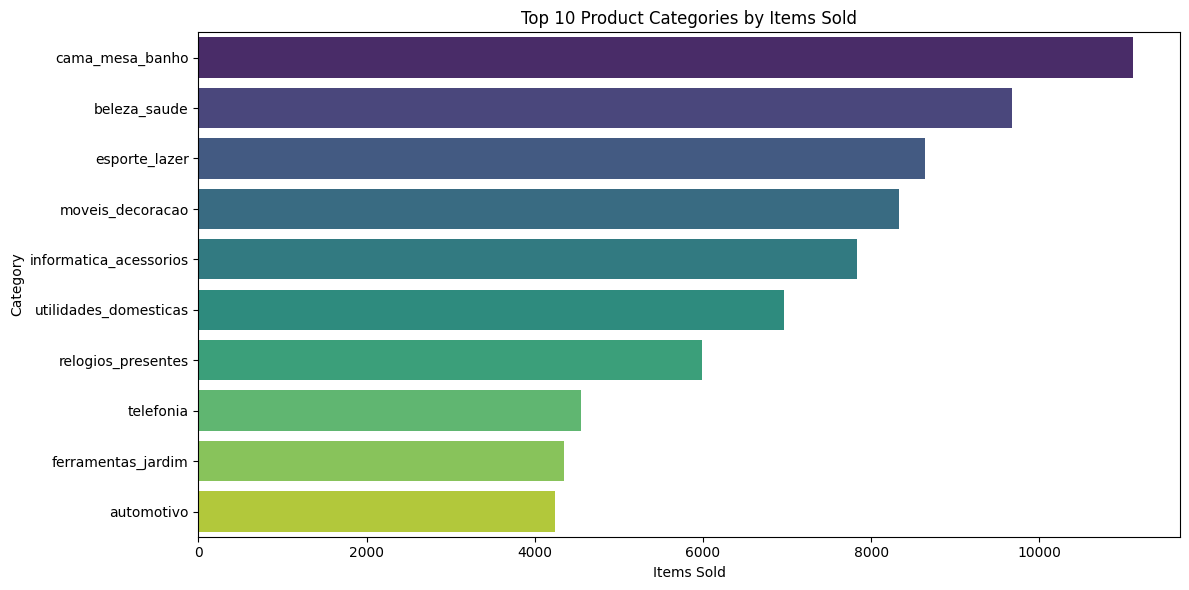

In [ ]:

top_cat_pd = top_categories.limit(10).toPandas()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=top_cat_pd, x="items_sold", y="product_category_name", palette="viridis")
plt.title("Top 10 Product Categories by Items Sold")
plt.xlabel("Items Sold")
plt.ylabel("Category")
plt.tight_layout()
plt.show()
